# Продвинутое глубокое обучение и обучение с подкреплением: ДЗ 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому **в качестве решения ожидается ссылка на Jupyter-ноутбук на вашем GitHub (или публичный, или с доступом для *snikolenko*); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

# Импорт библиотек

In [1]:
import random
from collections import defaultdict
from itertools import product
from math import ceil

import gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
FIGSIZE = (16, 8)
FONTSIZE = 16

plt.rcParams['axes.titlesize'] = FONTSIZE
plt.rcParams['axes.labelsize'] = FONTSIZE

# Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть **usable ace**), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
  * **hit**  — взять ещё одну карту;
  * **stand** — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (**bust**);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за **natural blackjack**: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 


1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [3]:
env = gym.make('Blackjack-v0', natural=True)
env.reset();

In [4]:
# sum in hand values, dealer open card values, usable_ace values:
STATES = list(product(range(4, 22), range(1, 11), (True, False)))

print(f'Total number of states: {len(STATES)}.')

Total number of states: 360.


In [5]:
def run_episode(env, pi, eps: float = 0.05):
    observation = env.reset()

    states, actions, rewards = [], [], []

    done = False
    while not done:
        states.append(observation)

        action = pi[observation] if random.random() > eps else env.action_space.sample()
        actions.append(action)

        observation, reward, done, _ = env.step(action)
        rewards.append(reward)

    return states, actions, rewards


def evaluate_pi(env, pi, num_experiments: int = 1,
                show_progress: bool = True):
    rewards = 0
    for _ in tqdm(range(num_experiments), desc='Evaluation (eps = 0)',
                  disable=not show_progress):
        _, _, ep_rewards = run_episode(env, pi, eps=0)
        rewards += ep_rewards[-1]
    return rewards / num_experiments

In [6]:
# Hit if sum in hand is less than 19, stick otherwise:
pi = {
    state: int(state[0] < 19)
    for idx, state in enumerate(STATES)
}

In [7]:
avg_reward = evaluate_pi(env, pi, num_experiments=500_000)

Evaluation (eps = 0): 100%|██████████| 500000/500000 [00:28<00:00, 17717.23it/s]


In [8]:
print(f'Оценка выигрыша от стратегии "stick if 19, 20 or 21": {avg_reward:.4f}')

Оценка выигрыша от стратегии "stick if 19, 20 or 21": -0.1816


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [9]:
def cumulative_moving_average(avg_val: float, cnt: int, cur_val: int) -> float:
    return (avg_val * cnt + cur_val) / (cnt + 1)

In [10]:
def monte_carlo_control(env,
                        eps: float = 0.05,
                        gamma: float = 0.9,
                        num_experiments: int = 1,
                        show_progress: bool = True):
    # Initialize policy:
    pi = defaultdict(int)

    # Initialize action-value function:
    q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Initialize state-action visits counter:
    state_action_cnt = defaultdict(int)

    total_rewards = []
    for i in tqdm(range(num_experiments),
                  desc=f'Training (eps = {eps:.2f}, gamma = {gamma:.2f})',
                  disable=not show_progress):
        states, actions, rewards = run_episode(env, pi, eps)
        total_rewards.append(rewards[-1])
        ep_states_actions = list(zip(states, actions))
        g = 0
        for t in range(len(states) - 1, -1, -1):
            g = gamma * g + rewards[t]
            if (states[t], actions[t]) not in ep_states_actions[:t]:
                q[states[t]][actions[t]] = cumulative_moving_average(
                    q[states[t]][actions[t]],
                    state_action_cnt[(states[t], actions[t])],
                    g,
                )
                state_action_cnt[(states[t], actions[t])] += 1
                pi[states[t]] = q[states[t]].argmax()

    return pi, total_rewards

Метод обучения сделан универсальным и будет переиспользоваться для изменённых сред в последующих пунктах.

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Обучение, подбор гиперпараметров и визуализация изменения среднего выигрыша (точнее, проигрыша 😅) по ходу обучения также вынесены в отдельную универсальную функцию, которая будет переиспользоваться здесь и далее.

In [11]:
def tune_hyperparams(env, num_experiments: int = 1, plot_every: int = 1,
                     show_progress: bool = True):
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

    eps_values = np.arange(0.05, 0.21, 0.05)
    gamma_values = np.arange(0.1, 1.0, 0.4)

    best_reward, best_pi, best_eps, best_gamma = -1000, None, None, None
    for i, (eps, gamma) in enumerate(product(eps_values, gamma_values)):
        # Training:
        pi, rewards = monte_carlo_control(
            env=env,
            eps=eps,
            gamma=gamma,
            num_experiments=num_experiments,
            show_progress=show_progress,
        )

        # Visualization:
        ys = [
            sum(rewards[i:i + plot_every]) / plot_every
            for i in range(0, len(rewards), plot_every)
        ]
        xs = np.arange(1, len(ys) + 1)
        ax.plot(
            xs, ys,
            label=f'eps = {eps:.2f}, gamma = {gamma:.2f}',
            color=f'C{i}'
        )

        # Best hyperparameters update:
        avg_reward = evaluate_pi(env, pi, num_experiments=plot_every)
        if avg_reward > best_reward:
            best_reward = avg_reward
            best_pi = pi
            best_eps = eps
            best_gamma = gamma

    plt.title('Average reward during training')
    plt.xlabel('Episode number')
    plt.xticks(xs, xs * plot_every)
    plt.ylabel('Current reward')
    plt.legend(loc='upper left')
    plt.grid()

    print(f'Наилучшая оценка выигрыша (усреднённого по {plot_every} раздач) ' \
          f'от стратегии: {best_reward:.4f}.')
    print(f'Достигается при параметрах: ' \
          f'eps = {best_eps:.2f}, gamma = {best_gamma:.1f}.')

Evaluation (eps = 0): 100%|██████████| 200000/200000 [00:11<00:00, 17268.44it/s]


Наилучшая оценка выигрыша (усреднённого по 200000 раздач) от стратегии: -0.0273.
Достигается при параметрах: eps = 0.20, gamma = 0.5.


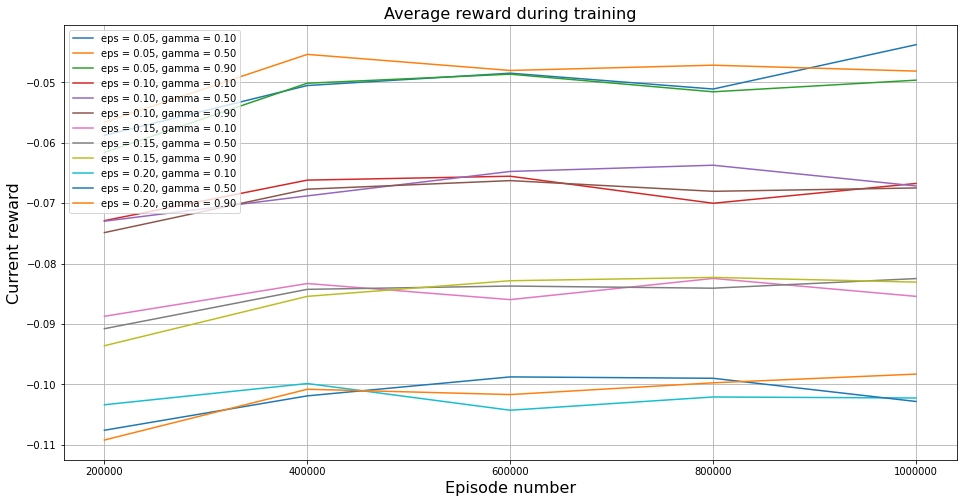

In [12]:
tune_hyperparams(env, num_experiments=1_000_000, plot_every=200_000)

Как можно заметить, во время обучения себя лучше показывают стратегии, обученные с одними параметрами, в то время как во время оценки — с другими. Это связано с тем, что на обучении мы не выключаем exploration (случайные действия с вероятностью `eps`) даже тогда, когда наша стратегия уже достаточно хороша, и агент продолжает выбирать "плохие" случайные действия, а при оценивании (`eps = 0`) этот эффект отсутствует.

# Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
* **double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [13]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class DoubleBlackjackEnv(gym.Env):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition.
        # Overrides self.natural.
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin.
                # Legacy implementation.
                reward = 1.5
        else:  # double: double the reward, draw one more card, and stick
            done = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))

        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [14]:
env = DoubleBlackjackEnv(natural=True)
env.reset();

Evaluation (eps = 0): 100%|██████████| 200000/200000 [00:11<00:00, 17495.37it/s]


Наилучшая оценка выигрыша (усреднённого по 200000 раздач) от стратегии: -0.0119.
Достигается при параметрах: eps = 0.20, gamma = 0.5.


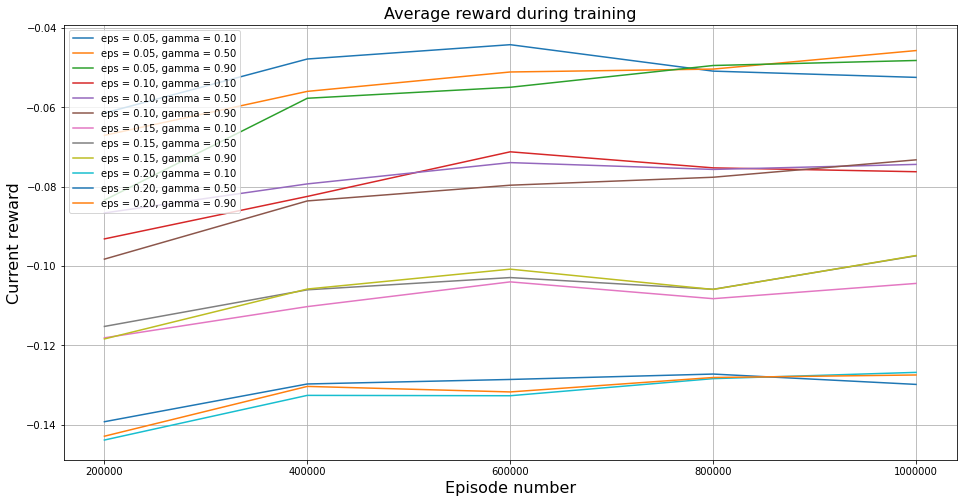

In [15]:
tune_hyperparams(env, num_experiments=1_000_000, plot_every=200_000)

# Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии о блекджеке](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а возможно, и нет).

In [16]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

halves = {
    1: -1,
    2: 0.5,
    3: 1,
    4: 1,
    5: 1.5,
    6: 1,
    7: 0.5,
    8: 0,
    9: -0.5,
    10: -1,
}


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class DoubleCountingBlackjackEnv(gym.Env):

    def __init__(self,
                 natural: bool = False,
                 sab: bool = False,
                 num_decks: int = 4,
                 reshuffle_on: int = 15):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Box(-22.0, 22.0, shape=(1, 1), dtype=np.float32),
        ))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition.
        # Overrides self.natural.
        self.sab = sab

        # Remaining cards in deck when reshuffling happens
        self.reshuffle_on = reshuffle_on

        # Total number of decks (6 by default)
        self.num_decks = num_decks

        self.reset_deck_and_count()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def draw_card(self, np_random):
        card = int(self.decks.pop(np_random.choice(len(self.decks))))
        self.count += halves[card]
        return card

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin.
                # Legacy implementation.
                reward = 1.5
        else:  # double: double the reward, draw one more card, and stick
            done = True
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))

        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0],
                usable_ace(self.player), self.count / ceil(len(self.decks) / 52))

    def reset_deck_and_count(self):
        # Stored decks
        self.decks = deck * 4 * self.num_decks
        # Stored count
        self.count = 0.0

    def reset(self):
        if len(self.decks) < self.reshuffle_on:
            self.reset_deck_and_count()

        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [17]:
env = DoubleCountingBlackjackEnv(natural=True, num_decks=4, reshuffle_on=15)
env.reset();

Evaluation (eps = 0): 100%|██████████| 200000/200000 [00:10<00:00, 19589.46it/s]


Наилучшая оценка выигрыша (усреднённого по 200000 раздач) от стратегии: -0.0267.
Достигается при параметрах: eps = 0.20, gamma = 0.1.


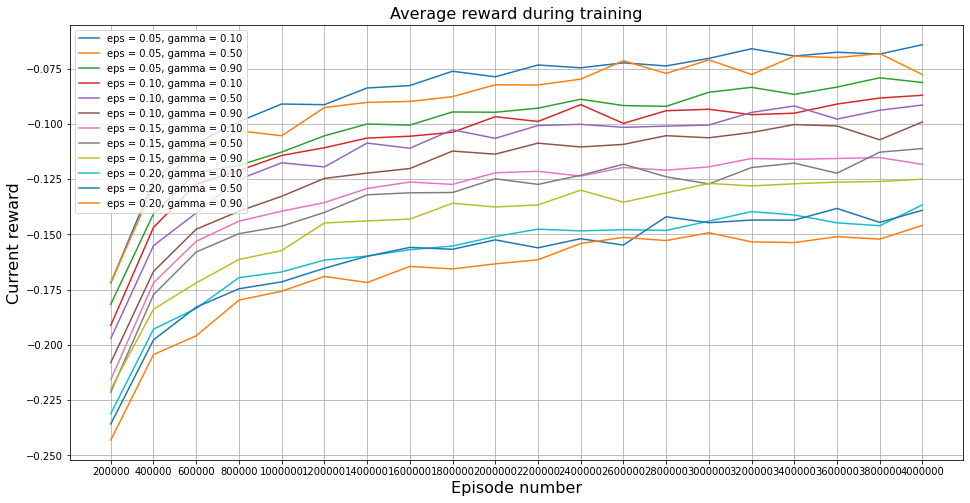

In [19]:
tune_hyperparams(env, num_experiments=4_000_000, plot_every=200_000)

# Часть четвёртая, опциональная

Ну и напоследок ещё парочка опциональных заданий за дополнительные баллы.

8. Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V\* или Q\*. Для этого вам придётся сначала оценить параметры модели, т.е. найти или обучить вероятности переходов между состояниями.

9. Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать **split**: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!